# Modelo de segregación de Schelling

En 1969, Thomas C. Schelling desarrolló un modelo simple pero sorprendente de segregación racial. El modelo estudia la dinámica de los barrios mixtos. Este modelo muestra cómo las interacciones locales pueden conducir a comportamiento emergente sorprendente. En particular, muestra que una preferencia relativamente leve por veciones de características similares (raza, creencia, nivel económico, etc.) puede conducir, en conjunto, al colapso de vecindarios mixtos y altos niveles de segregación.

En reconocimiento a esta y otras investigaciones, Schelling recibió el Premio Nobel de Ciencias Económicas 2005 (junto con Robert Aumann).

## ¿Cómo trabaja el modelo?
Supón que hay dos tipos de agentes: X y O. Los dos tipos de agentes pueden representar diferentes razas, etnias, estatus económico, etc. Dos poblaciones de los dos tipos de agentes se colocan inicialmente en ubicaciones aleatorias de un vecindario representado por una cuadrícula. Después de colocar todos los agentes en la cuadrícula, cada celda está ocupada por un agente o está vacía, como se muestra a continuación.
<center>
<img src="http://nifty.stanford.edu/2014/mccown-schelling-model-segregation/images/grid1.png" />
</center>
Ahora debemos determinar si cada agente está satisfecho con su ubicación actual. Un agente satisfecho es aquel que está rodeado por al menos un *t* por ciento de agentes que son como él. Este umbral *t* es el que se aplicará a todos los agentes del modelo, aunque en realidad todos pueden tener un umbral diferente con el que están satisfechos. Tenga en cuenta que cuanto mayor sea el umbral, mayor será la probabilidad de que los agentes no estén satisfechos con su ubicación actual.

Por ejemplo, si *t* = 30%, el agente *X* está satisfecho si al menos el 30% de sus vecinos también son *X*. Si menos del 30% son *X*, entonces el agente no está satisfecho y querrá cambiar su ubicación en la cuadrícula. Para el resto de esta explicación, supongamos un umbral *t* del 30%. Esto significa que a todos los agentes les parece bien estar en minoría siempre que haya al menos un 30% de agentes similares en las celdas adyacentes.

La imagen de abajo (izquierda) muestra un agente satisfecho porque el 50% de los vecinos de X también son X (50%> t). La siguiente X (derecha) no se satisface porque solo el 25% de sus vecinos son X (25% <t). Observe que en este ejemplo las celdas vacías no se cuentan al calcular la similitud.
<center>
<img src="http://nifty.stanford.edu/2014/mccown-schelling-model-segregation/images/grid2.png" />
</center>
Cuando un agente no está satisfecho, se puede trasladar a cualquier lugar vacante en la cuadrícula. Se puede utilizar cualquier algoritmo para elegir esta nueva ubicación. Por ejemplo, se puede elegir una celda seleccionada al azar, o el agente se puede mover a la ubicación disponible más cercana.

En la imagen de abajo (izquierda), todos los agentes insatisfechos tienen un asterisco junto a ellos. La imagen de la derecha muestra la nueva configuración después de que todos los agentes insatisfechos se hayan movido al azar a celdas desocupadas. Tenga en cuenta que la nueva configuración puede hacer que algunos agentes que estaban satisfechos anteriormente se sientan insatisfechos.
<center>
<img src="http://nifty.stanford.edu/2014/mccown-schelling-model-segregation/images/grid4.png" />
</center>
Todos los agentes insatisfechos deben moverse en la misma ronda. Una vez completada la ronda, comienza una nueva ronda y los agentes insatisfechos se trasladan una vez más a nuevas ubicaciones en la cuadrícula. Estas rondas continúan hasta que todos los agentes del vecindario estén satisfechos con su ubicación.

<p style='text-align: right;'> Fuente: <a href="http://nifty.stanford.edu/2014/mccown-schelling-model-segregation/">Schelling's Model of Segregation</a></p>

## Imports

Antes de empezar a crear el modelo del juego de la vida con multiagentes es necesario tener instalado los siguientes paquetes:
- `python`: asegúrense de usar la versión 3+.
- `mesa`: el framework de Python para el modelado de agentes.
- `numpy`: es una biblioteca de Python para el manejo de matrices, arreglos, manipulación matemática, lógica y mucho más.
- `matplotlib`: es una biblioteca para crear visualizaciones estáticas, animadas e interactivas en Python.

Para poder modelar el juego de la vida usando el framework de `mesa` es necesario importar dos clases: una para el modelo general, y otro para los agentes.

In [3]:
# Importamos las clases que se requieren para manejar los agentes (Agent) 
# y su entorno (Model). Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model

# Debido a que necesitamos que existe un solo agente por celda, elegimos 
# ''SingleGrid''.
from mesa.space import SingleGrid

# Con ''RandomActivation'', hacemos que todos los agentes se activen 
# ''al mismo tiempo''.
from mesa.time import RandomActivation

# Haremos uso de ''DataCollector'' para obtener información de cada 
# paso de la simulación.
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos 
# del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores 
# numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo 
# de ejecución de nuestro algoritmo.
import time
import datetime

In [4]:
class SegregationAgent(Agent):
    """ Este agente representa un individuo del modelo. A cada individuo
        se le asigna un tipo y un límite de tolerancia. """
    def __init__(self, unique_id, model, a_type, threshold):
        super().__init__(unique_id, model)
        self.type = a_type
        self.threshold = threshold

    def step(self):
        """ Este método especifica que debe realizar el agente. En este 
        caso, dependiendo del número de vecinos, el agente puede quedarse 
        en su celda o no (ver reglas en la parte superior). """
        neighbors = self.model.grid.get_neighbors(self.pos, moore=True,
                                                  include_center=False)
        same_type = 0
        total_neighbors = 0
        fraction = 0
        for neighbour in neighbors:
            if self.type == neighbour.type:
                same_type += 1
            total_neighbors +=1
        if total_neighbors != 0:
            fraction = same_type / total_neighbors

        if fraction < self.threshold:
            self.model.grid.move_to_empty(self)

In [5]:
def get_grid(model):
    """ Esta función nos permite obtener el estado de los diferentes 
        agentes. *param* model : Modelo del que obtendrá la información.
        *return* una matriz con la información del estado de cada uno 
        de los agentes."""
    grid = np.zeros( (model.grid.width, model.grid.height) )
    for (content, (x, y)) in model.grid.coord_iter():
        if (content == None):
            grid[x][y] = 0
        else:
            grid[x][y] = content.type
    return grid

In [6]:
class SegregationModel(Model):
    """ Define nuestro modelo, los agentes y su entorno."""
    def __init__(self, width, height, diff_types = 2,
                 threshold = .30, empty_cells = .20):
        super().__init__()
        num_agents = int( (width * height) * (1 - empty_cells) )
        self.grid = SingleGrid(width, height, torus = False)
        self.schedule = RandomActivation(self)
        # Aquí definimos el recolector para obtener el grid completo.
        self.datacollector = DataCollector(model_reporters={
            "Grid": get_grid})

        id = 0
        amount = num_agents // diff_types
        for i in range(1, (diff_types + 1)):
            for j in range(amount):
                a = SegregationAgent(id, self, i, threshold)
                self.grid.move_to_empty(a)
                self.schedule.add(a)
                id = id + 1

    def step(self):
        """ Ejecuta un paso de la simulación."""
        self.datacollector.collect(self)
        self.schedule.step()

In [7]:
WIDTH = 30
HEIGHT = 30
THRESHOLD = .60
TYPES = 3
EMPTY_CELLS = .20

# Definimos el número máximo de generaciones a correr
MAX_GENERATIONS = 60

# Registramos el tiempo de inicio y ejecutamos la simulación
start_time = time.time()
model = SegregationModel(WIDTH, HEIGHT, TYPES, THRESHOLD, EMPTY_CELLS)
for i in range(MAX_GENERATIONS):
    model.step()

# Imprimimos el tiempo que le tomó correr al modelo.
print('Tiempo de ejecución:',
      str(datetime.timedelta(seconds=(time.time() - start_time))))

Tiempo de ejecución: 0:00:00.216061


In [8]:
# Obtenemos la información que almacenó el colector, este nos entregará 
# un DataFrame de pandas que contiene toda la información.
all_grid = model.datacollector.get_model_vars_dataframe()

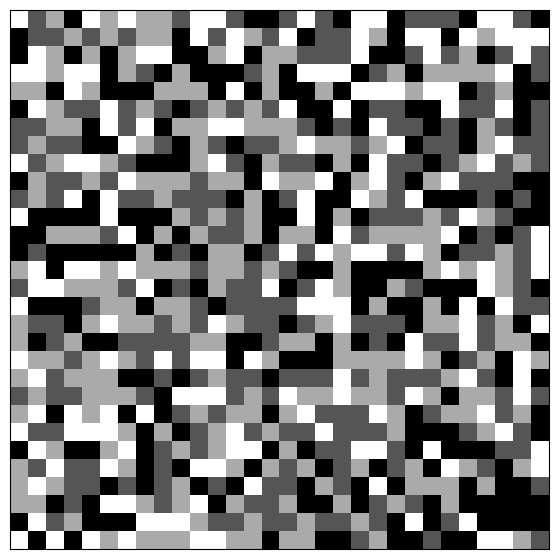

In [14]:
# Graficamos la información usando `matplotlib`
# %%capture

fig, axs = plt.subplots(figsize=(7,7))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grid.iloc[0,0], cmap=plt.cm.binary)

def animate(i):
    patch.set_data(all_grid.iloc[i,0])

anim = animation.FuncAnimation(fig, animate, frames=MAX_GENERATIONS)

In [15]:
anim